In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import necessary modules
import pickle

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OrdinalEncoder
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score

In [4]:
def change_gender(gender):
    
    if gender[0] == 'F':
        gender = 'Female'
        
    if gender[0] == 'M':
        gender = 'Male'
     
    return gender

In [5]:
def wrangle_customer_demo(filepath):
    
    df = pd.read_csv(filepath).set_index('customer_id')
    
    df['gender'] = df['gender'].apply(change_gender)
    
    df['job_industry_category'].fillna('Other', inplace=True)
    

    #Drop rows with empty values
    df.drop(index = df[df['DOB'].isna()].index, inplace= True)
    
    
    df['age'] = 2018 - df['DOB'].str.slice(0,4).astype(int)
    
    df.drop(index = df[df['age'] == 175].index, inplace = True)
    df[df['age'] == 2018]['age'].replace()
            
    df['owns_car'] = (df['owns_car'] == 'Yes').astype(bool)
    df['deceased_indicator'] = (df['deceased_indicator'] == 'Y')
    
    #Drop columns with high modularity or low impact
    drop_cols = ['first_name', 'last_name', 'job_title', 'DOB', 'deceased_indicator']
    df.drop(columns = drop_cols, inplace = True)
    
    
    return df

In [6]:
def wrangle_address(filepath):
    df = pd.read_csv(filepath)
    
    df.drop(columns = ['country', 'address'], inplace = True)
    
    df['state'] = df['state'].replace(to_replace = {'New South Wales' : 'NSW', 'Victoria': 'VIC'})
    
    return df

In [7]:
def wrangle_transact(filepath):
    
    df = pd.read_csv(filepath)
    
    df['online_order'] = df['online_order'].astype(bool)
    
    df.drop(index = df[df['brand'].isna()].index, inplace = True)
    
    df_sub = df[['customer_id', 'online_order', 'brand', 'product_line', 'product_class', 'product_size', 'list_price']]
    
    df_sub
    return df_sub

In [8]:
# Wrangle all data sets and return final dataframe
def wrangle(cust_demo_fpath, cust_add_fpath, cust_transact_fpath):
    
    df_cust_demo = wrangle_customer_demo(cust_demo_fpath)
    
    df_address = wrangle_address(cust_add_fpath)
    
    df_transact_sub = wrangle_transact(cust_transact_fpath)
    
    df_2 = df_cust_demo.merge(df_address, on='customer_id')
    
    online_order_prob = df_transact_sub.groupby('customer_id')['online_order'].mean() >= 0.5
    
    df_merged = df_2.merge(online_order_prob, on = 'customer_id')
    
    df_merged.drop(columns =['postcode', 'customer_id'], inplace = True)
    
    return df_merged

In [9]:
transact_df = wrangle_transact('../input/kpmg-internship/customer_transactions.csv')
transact_df.head()

,customer_id,online_order,brand,product_line,product_class,product_size,list_price
0,787,True,Giant Bicycles,Standard,medium,large,1765.30
1,2339,True,Giant Bicycles,Road,medium,medium,1538.99
2,247,False,Giant Bicycles,Standard,medium,large,1765.30
3,1842,False,Giant Bicycles,Standard,medium,small,1311.44
4,3002,True,Giant Bicycles,Road,medium,medium,1538.99


In [10]:
# Wrangle data
df_merged = wrangle(
    '../input/kpmg-internship/customer_demographic.csv',
    '../input/kpmg-internship/customer_address.csv', 
    '../input/kpmg-internship/customer_transactions.csv'
)
df_merged.head(15)

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,age,state,property_valuation,online_order
0,Female,93,Health,Mass Customer,True,11.0,65,NSW,10,True
1,Male,81,Financial Services,Mass Customer,True,16.0,38,NSW,10,False
2,Male,33,IT,Mass Customer,False,7.0,57,QLD,9,True
3,Female,56,Other,Affluent Customer,True,8.0,41,NSW,4,False
4,Male,35,Retail,High Net Worth,True,13.0,52,VIC,9,False
5,Female,6,Financial Services,Affluent Customer,True,11.0,42,NSW,9,True
6,Male,31,Other,Mass Customer,False,7.0,56,NSW,4,True
7,Female,97,Argiculture,Affluent Customer,True,8.0,45,NSW,12,False
8,Male,99,Property,Mass Customer,False,9.0,64,VIC,8,True
9,Male,58,Manufacturing,Mass Customer,False,8.0,24,QLD,4,False


In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3412 entries, 0 to 3411
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3412 non-null   object 
 1   past_3_years_bike_related_purchases  3412 non-null   int64  
 2   job_industry_category                3412 non-null   object 
 3   wealth_segment                       3412 non-null   object 
 4   owns_car                             3412 non-null   bool   
 5   tenure                               3412 non-null   float64
 6   age                                  3412 non-null   int64  
 7   state                                3412 non-null   object 
 8   property_valuation                   3412 non-null   int64  
 9   online_order                         3412 non-null   bool   
dtypes: bool(2), float64(1), int64(3), object(4)
memory usage: 246.6+ KB


# Split The Data

In [12]:
target = 'online_order'
X = df_merged.drop(columns = target)
y = df_merged[target]
print(X.shape)

(3412, 9)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)

(2729, 9)
(2729,)


## Get my Baseline

In [14]:
baseline_acc = y.value_counts(normalize= True).max()
baseline_acc

0.597303634232122

### Important to Note:
True is our Majority Class

True is also our Positive Class

## Select my model

I will go with a Pipeline that has a Ordinal encoder and RandomForestClassifier in a GridSearchCV model 

In [15]:
clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)
clf

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [16]:
params = {
    'randomforestclassifier__n_estimators': range(50,151,25),
    'randomforestclassifier__max_depth':range(10,50,10)
         }

In [17]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(50, 151, 25)},
             verbose=1)

In [18]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(50, 151, 25)},
             verbose=1)

# Now, We Evaluate our Model

In [19]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.807305,0.022970,0.060525,0.005620,10,150,"{'randomforestclassifier__max_depth': 10, 'ran...",0.569597,0.582418,0.578755,0.565934,0.603670,0.580075,0.013219,1
2,0.534567,0.001681,0.043361,0.001461,10,100,"{'randomforestclassifier__max_depth': 10, 'ran...",0.573260,0.595238,0.569597,0.556777,0.598165,0.578607,0.015783,2
3,0.656670,0.006703,0.049403,0.001310,10,125,"{'randomforestclassifier__max_depth': 10, 'ran...",0.573260,0.580586,0.571429,0.553114,0.601835,0.576045,0.015752,3
1,0.414562,0.002202,0.036138,0.000555,10,75,"{'randomforestclassifier__max_depth': 10, 'ran...",0.578755,0.586081,0.571429,0.543956,0.590826,0.574209,0.016497,4
0,0.292125,0.006967,0.028625,0.000671,10,50,"{'randomforestclassifier__max_depth': 10, 'ran...",0.565934,0.584249,0.565934,0.534799,0.588991,0.567981,0.019055,5
18,0.810482,0.010812,0.055822,0.001412,40,125,"{'randomforestclassifier__max_depth': 40, 'ran...",0.558608,0.573260,0.532967,0.536630,0.598165,0.559926,0.024130,6
13,0.795755,0.001474,0.055383,0.001504,30,125,"{'randomforestclassifier__max_depth': 30, 'ran...",0.558608,0.562271,0.538462,0.536630,0.598165,0.558827,0.022212,7
12,0.646676,0.009005,0.047884,0.001547,30,100,"{'randomforestclassifier__max_depth': 30, 'ran...",0.545788,0.582418,0.553114,0.534799,0.577982,0.558820,0.018458,8
17,0.653126,0.010086,0.048190,0.000769,40,100,"{'randomforestclassifier__max_depth': 40, 'ran...",0.545788,0.580586,0.551282,0.534799,0.577982,0.558087,0.018121,9
19,0.906204,0.075684,0.058625,0.006620,40,150,"{'randomforestclassifier__max_depth': 40, 'ran...",0.551282,0.565934,0.543956,0.527473,0.594495,0.556628,0.022626,10


In [20]:
model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 150}

In [21]:
model.best_score_

0.5800746042947877

Unfortunately, this model did not beat our baseline accuracy score of 0.5097

In [22]:
model.score(X_test, y_test)

0.5695461200585652

## Save the Model to a Pickle File 

In [23]:
with open('rfclf_onlineorder_2.pkl', 'wb') as f:
    pickle.dump(model, f)

<AxesSubplot:title={'center':'Gini Importance'}, ylabel='Feature Importance'>

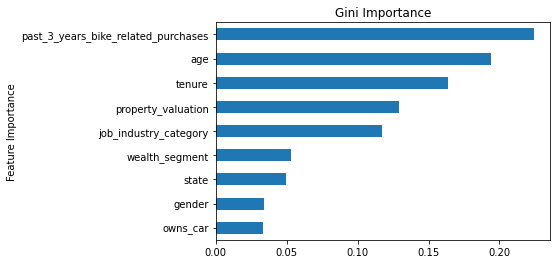

In [24]:
importances = model.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
features = model.best_estimator_.named_steps['randomforestclassifier'].feature_names_in_

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.plot(kind = 'barh', ylabel = 'Feature', xlabel = 'Feature Importance', title='Gini Importance')